# Classification - Pima Indians Diabetes Dataset

(this is the other diabetes notebook, where I conducted further research)

In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.model_selection import GridSearchCV

from plotly.subplots import make_subplots
from plotly import graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import accuracy_score

random_state = 42

def replace_nan(df, strategy='mean'):
    df_nan = df.copy()
    features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    df_nan[features] = df[features].replace(0, np.NaN)

    for col in features:
        if strategy == 'mean':
            df_nan[col].fillna(df_nan[col].mean(), inplace=True)
        elif strategy == 'median':
            df_nan[col].fillna(df_nan[col].median(), inplace=True)
        elif strategy == 'mixed':
            if col in ['Glucose', 'BloodPressure', 'BMI']:
                df_nan[col].fillna(df_nan[col].mean(), inplace=True)
            else:
                df_nan[col].fillna(df_nan[col].median(), inplace=True)

    return df_nan

def scale_split_data(df):
    X = StandardScaler().fit_transform(df.drop(["Outcome"], axis=1))
    y = df['Outcome'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)

    return X_train, X_test, y_train, y_test

def balance_data(df, majority_df, target_col='Outcome'):
    majority_class = majority_df
    minority_class = df[df[target_col] == 1]
    
    majority_count = majority_class.shape[0]
    
    # Upsample minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=majority_count, random_state=random_state)

    balanced_df = pd.concat([majority_class, minority_upsampled])
    return balanced_df

def compare_model_accuracy(plot_title, subplot_title_1, models_set_1, X_train_1, X_test_1, y_train_1, y_test_1,
                            subplot_title_2, models_set_2, X_train_2, X_test_2, y_train_2, y_test_2):
    accuracies_set_1 = []
    accuracies_set_2 = []

    for model in models_set_1:
        y_pred_1 = model.fit(X_train_1, y_train_1).predict(X_test_1)
        accuracies_set_1.append(accuracy_score(y_test_1, y_pred_1))

    for model in models_set_2:
        y_pred_2 = model.fit(X_train_2, y_train_2).predict(X_test_2)
        accuracies_set_2.append(accuracy_score(y_test_2, y_pred_2))

    # Calculate average accuracy
    average_accuracy_set_1 = np.mean(accuracies_set_1)
    average_accuracy_set_2 = np.mean(accuracies_set_2)

    # Output the results in a bar chart
    model_names_set_1 = [model.__class__.__name__ for model in models_set_1]
    model_names_set_2 = [model.__class__.__name__ for model in models_set_2]

    fig = make_subplots(rows=2, cols=2, subplot_titles=(subplot_title_1, subplot_title_2),
                        row_heights=[0.85, 0.15], shared_yaxes=True)

    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    fig.add_trace(go.Bar(x=accuracies_set_1, y=model_names_set_1, orientation='h',
                         text=np.round(accuracies_set_1, 3), textposition='auto', marker=dict(color=bar_colors),
                         textfont=dict(color='white'), showlegend=False),
                  row=1, col=1)

    fig.add_trace(go.Bar(x=[average_accuracy_set_1], y=["Average Accuracy"], orientation='h',
                         marker=dict(color='#ff0ee7'), text=np.round([average_accuracy_set_1], 3),
                         textposition='auto', textfont=dict(color='white'), showlegend=False),
                  row=2, col=1)

    fig.add_trace(go.Bar(x=accuracies_set_2, y=model_names_set_2, orientation='h',
                         text=np.round(accuracies_set_2, 3), textposition='auto', marker=dict(color=bar_colors),
                         textfont=dict(color='white'), showlegend=False),
                  row=1, col=2)

    fig.add_trace(go.Bar(x=[average_accuracy_set_2], y=["Average Accuracy"], orientation='h',
                         marker=dict(color='#ff0ee7'), text=np.round([average_accuracy_set_2], 3),
                         textposition='auto', textfont=dict(color='white'), showlegend=False),
                  row=2, col=2)

    fig.update_layout(title={'text': plot_title, 'x': 0.5, 'y': 0.9})
    iplot(fig)

def compare_balanced_vs_unbalanced_accuracy(original_df, balanced_df, strategy, models, plot_title):
    X_original = StandardScaler().fit_transform(original_df.drop(["Outcome"], axis=1))
    y_original = original_df['Outcome'].values

    X_balanced = StandardScaler().fit_transform(balanced_df.drop(["Outcome"], axis=1))
    y_balanced = balanced_df['Outcome'].values

    X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=1/3, random_state=random_state)
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=1/3, random_state=random_state)

    compare_model_accuracy(plot_title, f"{strategy} + Unbalanced", models, X_train_original, X_test_original, y_train_original, y_test_original, f"{strategy} + Balanced", models, X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced)

    # Return the train and test sets for the balanced data only
    return X_balanced, y_balanced, X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced

def compare_z_score_pairs(X, y, X_test, y_test, z_pairs, strategy, models, plot_title):
    filtered_datasets = []

    # Compare other z-score pairs
    for i, (z1, z2) in enumerate(z_pairs, start=1):
        # Filter the data based on z-scores to remove outliers
        z_filtered_1 = (np.abs(stats.zscore(X)) < z1).all(axis=1)
        X_filtered_1 = X[z_filtered_1]
        y_filtered_1 = y[z_filtered_1]

        z_filtered_2 = (np.abs(stats.zscore(X)) < z2).all(axis=1)
        X_filtered_2 = X[z_filtered_2]
        y_filtered_2 = y[z_filtered_2]

        # Split the filtered data into training and test sets
        X_train_filtered_1, X_test_filtered_1, y_train_filtered_1, y_test_filtered_1 = train_test_split(
            X_filtered_1, y_filtered_1, test_size=1/3, random_state=random_state, stratify=y_filtered_1
        )

        X_train_filtered_2, X_test_filtered_2, y_train_filtered_2, y_test_filtered_2 = train_test_split(
            X_filtered_2, y_filtered_2, test_size=1/3, random_state=random_state, stratify=y_filtered_2
        )

        # Save the filtered datasets
        filtered_datasets.append({
            "strategy": strategy,
            "z1": z1,
            "X_train": X_train_filtered_1,
            "X_test": X_test_filtered_1,
            "y_train": y_train_filtered_1,
            "y_test": y_test_filtered_1
        })

        filtered_datasets.append({
            "strategy": strategy,
            "z2": z2,
            "X_train": X_train_filtered_2,
            "X_test": X_test_filtered_2,
            "y_train": y_train_filtered_2,
            "y_test": y_test_filtered_2
        })

        # Compare the accuracy score of the models with the filtered datasets vs each other
        compare_model_accuracy(
            f"{plot_title}: {strategy}",
            f"{strategy} + Bal + Z{z1}",
            models,
            X_test_filtered_2,
            X_test,
            y_test_filtered_2,
            y_test,
            f"{strategy} + Bal + Z{z2}",
            models,
            X_test_filtered_1,
            X_test,
            y_test_filtered_1,
            y_test
        )

    return filtered_datasets

def compare_models(model_sets, set_labels):
    fig = go.Figure()

    colors = ['#2ca02c', '#1f77b4']

    for models, title, color in zip(model_sets, set_labels, colors):
        accuracies = []
        labels = []

        for model, X_test, y_test, X_train, y_train in models:
            # Fit the model
            model.fit(X_train, y_train)

            # Make predictions and calculate accuracy
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(round(accuracy, 3))
            labels.append(type(model).__name__)

        fig.add_trace(go.Bar(
            y=labels,
            x=accuracies,
            name=title,
            orientation='h',
            marker=dict(color=color),
            text=accuracies,
            textposition='inside',
            textfont=dict(color='white')
        ))

    # Reverse the order of legend items manually
    fig.update_layout(
        title='Model Comparison',
        xaxis_title='Accuracy',
        yaxis_title='Model',
        barmode='group',
        margin=dict(l=0, r=0, t=50, b=0),
        legend=dict(x=1, y=1, traceorder='reversed', orientation='v'),
    )

    fig.show()

models_with_default_parameters = \
    [  
            RandomForestClassifier(random_state=random_state),
            DecisionTreeClassifier(random_state=random_state),
            SVC(random_state=random_state),
            KNeighborsClassifier(),
            LogisticRegression(random_state=random_state)
    ]

# 1. Obtain

In [51]:
diabetes_df = pd.read_csv('pima-indians-diabetes.csv')
# credits: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names
features_for_column = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
diabetes_df.columns = features_for_column
diabetes_df.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


## 1.1 Initial observations
1. **Scrub**
    - missing values? 
        - the count of each predictor is 768
            - **->** there are no missing values
    - incorrect values?
        - min of 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI' is 0, which is not possible
            - **->** replace them with mean or median (depending on the distribution)
2. **Explore**
    - outcome variable type?
        - binary (0 = no diabetes, 1 = diabetes) 
            - **->** binary classification problem
3. **Model**
    - biased dataset?
        - 0.35 mean of outcome indicates a moderate bias towards patients without diabetes
            - **->** balance the dataset
    - scaling needed?
        - mean of 'Glucose' 120.89 and 'BMI' 31.99 are not on the same scale
            - **->** scale the dataset, otherwise the model will be biased towards the predictors with the largest values

# 2. Scrub

## 2.1 Replace incorrect 0 values
determine the correct mean or median for each predictor by plotting the distributions

array([[<Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>],
       [<Axes: title={'center': 'BMI'}>, <Axes: >]], dtype=object)

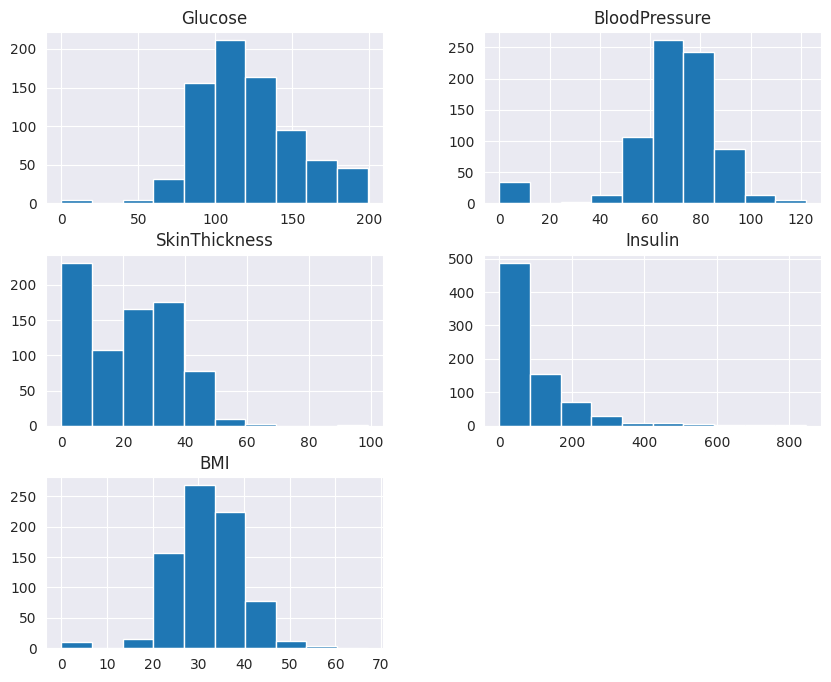

In [52]:
diabetes_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].hist(figsize=(10, 8))

> 1. the distribution of Glucose, BloodPressure and BMI is bell-shaped
>    - -> replace the missing values with the mean
> 2. the distribution of SkinThickness and Insulin is skewed
>    - -> replace the missing values with the median

## 2.1 Replace 0 values in various ways

In [53]:
diabetes_df_mean = replace_nan(diabetes_df, strategy='mean')
diabetes_df_median = replace_nan(diabetes_df, strategy='median')
diabetes_df_mixed = replace_nan(diabetes_df, strategy='mixed')

X_train_mean, X_test_mean, y_train_mean, y_test_mean = scale_split_data(diabetes_df_mean)
X_train_median, X_test_median, y_train_median, y_test_median = scale_split_data(diabetes_df_median)
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = scale_split_data(diabetes_df_mixed)

compare_model_accuracy("NaN replacement compare", "Median", models_with_default_parameters,
                       X_train_median, X_test_median, y_train_median, y_test_median,
                       "Mean", models_with_default_parameters, X_train_mean, X_test_mean, y_train_mean, y_test_mean)
compare_model_accuracy("", "Mixed", models_with_default_parameters,
                       X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed,
                       "Mean", models_with_default_parameters, X_train_mean, X_test_mean, y_train_mean, y_test_mean)

Sadly, the differences are very marginal, but I am determined in my resolve and will follow this to the end!
--> Track the accuracy score of each model with different parameters

## 3. Explore

<Axes: >

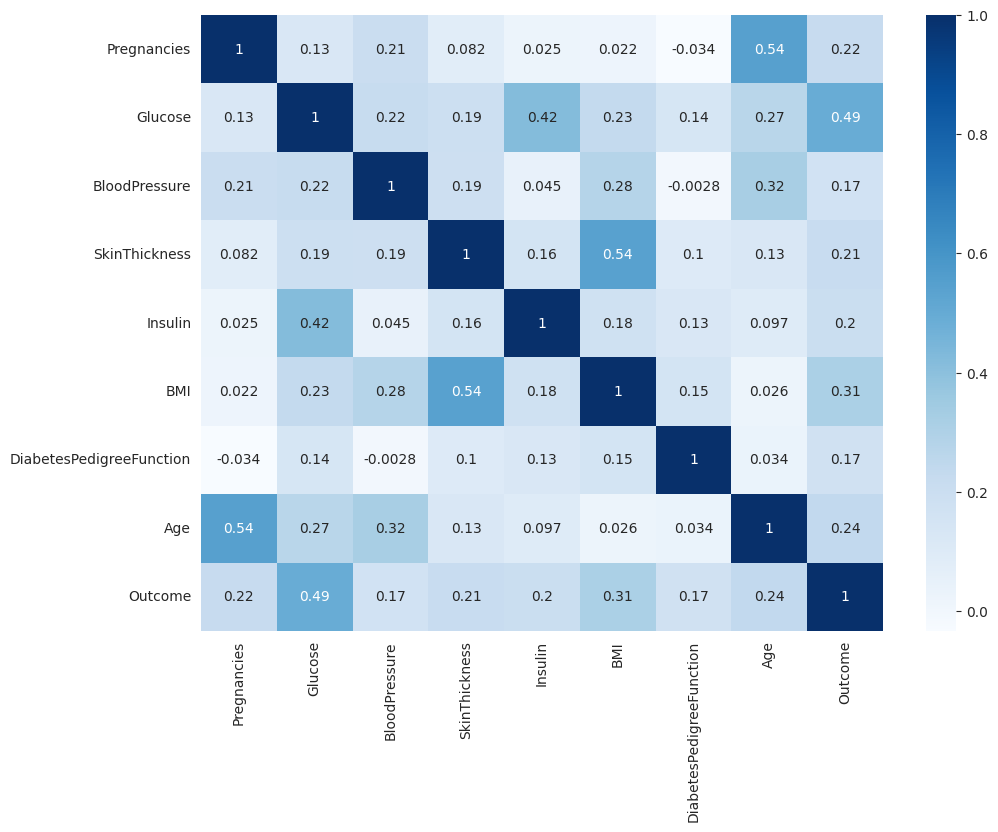

In [54]:
corr = diabetes_df_mixed.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, annot=True, cmap="Blues")

- observed correlations
    - (glucose, bmi) R outcome
    - pregnancies R age
    - blood pressure R insulin
    - skin thickness R bmi
    - insulin R glucose

# 4. Model

## 4.1 Balance
by upsampling the minority class (Outcome = 1) to the same size as the majority class (Outcome = 0)

In [55]:
diabetes_df_mixed['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [56]:
# balance the dataset for each NaN replacement strategy

diabetes_df_majority_mean = diabetes_df_mean[diabetes_df_mean['Outcome'] == 0]
diabetes_df_mean_balanced = balance_data(diabetes_df_mean, diabetes_df_majority_mean, target_col='Outcome')

diabetes_df_majority_median = diabetes_df_median[diabetes_df_median['Outcome'] == 0]
diabetes_df_median_balanced = balance_data(diabetes_df_median, diabetes_df_majority_median, target_col='Outcome')

diabetes_df_majority_mixed = diabetes_df_mixed[diabetes_df_mixed['Outcome'] == 0]
diabetes_df_mixed_balanced = balance_data(diabetes_df_mixed, diabetes_df_majority_mixed, target_col='Outcome')

# dataframes with balanced dataset
print(diabetes_df_mixed_balanced['Outcome'].value_counts())

# compare the accuracy score of the models with the balanced dataset vs the unbalanced dataset
# Apply the function for different strategies
X_mean_bal, y_mean_bal, X_train_mean_bal, X_test_mean_bal, y_train_mean_bal, y_test_mean_bal = compare_balanced_vs_unbalanced_accuracy(diabetes_df_mean, diabetes_df_mean_balanced, "Mean", models_with_default_parameters, "Balance compare")
X_median_bal, y_median_bal, X_train_median_bal, X_test_median_bal, y_train_median_bal, y_test_median_bal = compare_balanced_vs_unbalanced_accuracy(diabetes_df_median, diabetes_df_median_balanced, "Median", models_with_default_parameters, "")
X_mixed_bal, y_mixed_bal, X_train_mixed_bal, X_test_mixed_bal, y_train_mixed_bal, y_test_mixed_bal = compare_balanced_vs_unbalanced_accuracy(diabetes_df_mixed, diabetes_df_mixed_balanced, "Mixed", models_with_default_parameters, "")

Outcome
0    500
1    500
Name: count, dtype: int64


> balancing the dataset improves the accuracy score in all cases
--> working with the balanced datasets from now on

## 4.2 Z-Score
- remove outliers by filtering the data based on z-scores

In [57]:
# pairs of z-scores to compare
z_pairs_to_compare = [(1, 2), (3, 4), (5, 6)]

# Compare the accuracy score of the models with the filtered datasets vs each other
filtered_datasets_mean = compare_z_score_pairs(X_mean_bal, y_mean_bal, X_test_mean_bal, y_test_mean_bal, z_pairs_to_compare, "Mean", models_with_default_parameters, "Z-Score compare")
filtered_datasets_median = compare_z_score_pairs(X_median_bal, y_median_bal, X_test_median_bal, y_test_median_bal, z_pairs_to_compare, "Median", models_with_default_parameters, "Z-Score compare")
filtered_datasets_mixed = compare_z_score_pairs(X_mixed_bal, y_mixed_bal, X_test_mixed_bal, y_test_mixed_bal, z_pairs_to_compare, "Mixed", models_with_default_parameters, "Z-Score compare")

These are the best combinations for each model:

| Model                  | Accuracy | Strategy         |
|------------------------|----------|------------------|
| Logistic Regression    | 0.763    | Median + Bal     |
| K-Nearest Neighbors    | 0.766    | Mixed + Bal + Z4 |
| Support Vector Machine | 0.823    | Mean + Bal + Z3  |
| Decision Tree          | 0.835    | Mean + Bal + Z6  |
| Random Forest          | 0.88     | Mean + Bal + Z6  |                 

In [58]:
# load the best combinations for each model

# for KNN
mixed_index_z2_4 = next((index for index, data in enumerate(filtered_datasets_mixed) if data.get('z2') == 4), None)
X_train_mixed_bal_z4 = filtered_datasets_mixed[mixed_index_z2_4]['X_train']
y_train_mixed_bal_z4 = filtered_datasets_mixed[mixed_index_z2_4]['y_train']
X_test_mixed_bal_z4 = filtered_datasets_mixed[mixed_index_z2_4]['X_test']
y_test_mixed_bal_z4 = filtered_datasets_mixed[mixed_index_z2_4]['y_test']

# for SVM
mean_index_z1_3 = next((index for index, data in enumerate(filtered_datasets_mean) if data.get('z1') == 3), None)
X_train_mean_bal_z3 = filtered_datasets_mean[mean_index_z1_3]['X_train']
y_train_mean_bal_z3 = filtered_datasets_mean[mean_index_z1_3]['y_train']
X_test_mean_bal_z3 = filtered_datasets_mean[mean_index_z1_3]['X_test']
y_test_mean_bal_z3 = filtered_datasets_mean[mean_index_z1_3]['y_test']

# for Decision Tree and Random Forest
mean_index_z1_6 = next((index for index, data in enumerate(filtered_datasets_mean) if data.get('z2') == 6), None)
X_train_mean_bal_z6 = filtered_datasets_mean[mean_index_z1_6]['X_train']
y_train_mean_bal_z6 = filtered_datasets_mean[mean_index_z1_6]['y_train']
X_test_mean_bal_z6 = filtered_datasets_mean[mean_index_z1_6]['X_test']
y_test_mean_bal_z6 = filtered_datasets_mean[mean_index_z1_6]['y_test']

## 4.3 Tuning
- tune the parameters of the models to further improve the accuracy score with GridSearchCV
- compare the results with the default parameters

### 4.3.1 Logistic Regression

In [59]:
param_grid_logreg = {
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False],
    'n_jobs': [-1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [50, 100, 150],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Suppress warnings, as some parameters may not be compatible with each other
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    grid_search_logreg = GridSearchCV(estimator=LogisticRegression(random_state=random_state), param_grid=param_grid_logreg, scoring='accuracy')
    grid_search_logreg.fit(X_train_median_bal, y_train_median_bal)
    
print(f"Determined parameters: {grid_search_logreg.best_params_}")

Determined parameters: {'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': -1, 'solver': 'newton-cg'}


### 4.3.2 K-Nearest Neighbors

In [60]:
param_grid_knn = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski', 'manhattan', 'euclidean'],
    'n_jobs': [-1],
    'n_neighbors': [7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, scoring='accuracy')
    grid_search_knn.fit(X_train_mixed_bal_z4, y_train_mixed_bal_z4)
    
print(f"Determined parameters: {grid_search_knn.best_params_}")

Determined parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 11, 'weights': 'distance'}


### 4.3.3 Support Vector Machine

In [61]:
param_grid_svc = {
    'gamma': [1, 2, 4, 6, 8, 10, 'auto', 'scale'],
    'decision_function_shape': ['ovo', 'ovr'],
    'tol': [1e-1, 0, 1e+1],
    'break_ties': [True, False],
    'shrinking': [True, False],
    'probability': [True, False]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    grid_search_svc = GridSearchCV(estimator=SVC(random_state=random_state), param_grid=param_grid_svc, scoring='accuracy')
    grid_search_svc.fit(X_train_mean_bal_z3, y_train_mean_bal_z3)
    
print(f"Determined parameters: {grid_search_svc.best_params_}")

Determined parameters: {'break_ties': True, 'decision_function_shape': 'ovr', 'gamma': 6, 'probability': True, 'shrinking': True, 'tol': 0.1}


### 4.3.4 Decision Tree

In [62]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2', None],
    'splitter': ['best', 'random'],
    'ccp_alpha': [0, 0.1, 0.2, 0.3]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=random_state), param_grid=param_grid_dt, scoring='accuracy')
    grid_search_dt.fit(X_train_mean_bal_z6, y_train_mean_bal_z6)

print(f"Determined parameters: {grid_search_dt.best_params_}")

Determined parameters: {'ccp_alpha': 0, 'criterion': 'gini', 'max_features': 'log2', 'splitter': 'best'}


### 4.3.5 Random Forest

In [63]:
param_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2', 'sqrt', None],
    'ccp_alpha': [0, 0.1, 0.2],
    'oob_score': [True, False],
    'n_jobs': [-1]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=random_state), param_grid=param_grid_rf, scoring='accuracy')
    grid_search_rf.fit(X_train_mean_bal_z6, y_train_mean_bal_z6)

print(f"Determined parameters: {grid_search_rf.best_params_}")

Determined parameters: {'ccp_alpha': 0, 'criterion': 'gini', 'max_features': None, 'n_jobs': -1, 'oob_score': True}


## 4.4 Model accuracy

In [64]:
models_gridsearch_xy = [
    [RandomForestClassifier(random_state=random_state, **grid_search_rf.best_params_), X_test_mixed_bal_z4, y_test_mixed_bal_z4, X_train_mixed_bal_z4, y_train_mixed_bal_z4],
    [DecisionTreeClassifier(random_state=random_state, **grid_search_dt.best_params_), X_test_mean_bal_z3, y_test_mean_bal_z3, X_train_mean_bal_z3, y_train_mean_bal_z3],
    [SVC(random_state=random_state, **grid_search_svc.best_params_), X_test_mean_bal_z3, y_test_mean_bal_z3, X_train_mean_bal_z3, y_train_mean_bal_z3],
    [KNeighborsClassifier(**grid_search_knn.best_params_), X_test_mixed_bal_z4, y_test_mixed_bal_z4, X_train_mixed_bal_z4, y_train_mixed_bal_z4],
    [LogisticRegression(random_state=random_state, **grid_search_logreg.best_params_), X_test_median_bal, y_test_median_bal, X_train_median_bal, y_train_median_bal]
]

models_default_xy = [
    [RandomForestClassifier(random_state=random_state), X_test_mixed_bal_z4, y_test_mixed_bal_z4, X_train_mixed_bal_z4, y_train_mixed_bal_z4],
    [DecisionTreeClassifier(random_state=random_state), X_test_mean_bal_z3, y_test_mean_bal_z3, X_train_mean_bal_z3, y_train_mean_bal_z3],
    [SVC(random_state=random_state), X_test_mean_bal_z3, y_test_mean_bal_z3, X_train_mean_bal_z3, y_train_mean_bal_z3],
    [KNeighborsClassifier(), X_test_mixed_bal_z4, y_test_mixed_bal_z4, X_train_mixed_bal_z4, y_train_mixed_bal_z4],
    [LogisticRegression(random_state=random_state), X_test_median_bal, y_test_median_bal, X_train_median_bal, y_train_median_bal]
]

compare_models([models_gridsearch_xy, models_default_xy], ['GridSearchCV', 'Default'])

Good accuracy here, but balancing the dataset means generating synthetic data.
How those relatively overfitted models hold up in the future can be questioned.